## 1. Data

In [94]:
# Import the libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [146]:
# Read the hero-network.csv data
heroNetwork = pd.read_csv(os.getcwd()+"/Data/hero-network.csv")

In [147]:
# lenght of the data
len(heroNetwork)

574467

As we can see, the lenght of the heroNetwork data is 574467. This data shows the edges between heroes that appear in the same comic. 

In [97]:
heroNetwork.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [148]:
# Convert our heroNetwork to a dataframe
heroNetworkDf = pd.DataFrame(heroNetwork)

In [149]:
# Read the edges.csv data
edges = pd.read_csv(os.getcwd()+"/Data/edges.csv")

In [150]:
# Convert the edges data to dataframe
edgesDf = pd.DataFrame(edges)

### Data Preprocessing

#### 1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency will be solved in the bellow codes:

In [151]:
# Write a function to return the differences between two files
def compare(string1, string2):
    temp= []
    for i in string1:
        if i not in string2:
            temp.append(i)
    return temp

In [183]:
# Find the differnces between to files that have to modify
merge = heroNetworkDf.hero1.tolist() + heroNetworkDf.hero2.tolist()
unique = list(set(merge))
differ = compare(unique, list(edgesDf.hero))
differ

[]

In [182]:
# Delete the words that don't have extra space from the differ list
differInEdge2 = ['BLADE' , 'SABRE' , 'SPIDER-MAN/PETER PAR']
for elem in differInEdge2:
    differ.remove(elem)
differ

ValueError: list.remove(x): x not in list

In [154]:
# Deleting the extra space from the end of the some words in heroNetworkDf
for col in heroNetworkDf.columns:
    heroNetworkDf[col] = heroNetworkDf[col].apply(lambda x: x[0:-1] if x in differ else x)

In [155]:
# Cleaning edgesDf from the extra '/'
edgesDf.hero = edgesDf.hero.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [157]:
# Fix the name 'SPIDER-MAN/PETER PAR' in 'hero-network.csv'
for col in heroNetworkDf.columns:
        heroNetworkDf[col] = heroNetworkDf[col].apply(lambda x: 'SPIDER-MAN/PETER PARKER' if x=='SPIDER-MAN/PETER PAR' else x)

In [191]:
# Check if there is any differences between the hero's names in 2 files
merge = heroNetworkDf.hero1.tolist() + heroNetworkDf.hero2.tolist()
unique2 = list(set(merge))
differ2 = compare(unique2, list(edgesDf.hero))
differ2

[]

As we can see, we got the blank list from the compare function. It means all tree reasons that caused inconsistency were fixed.

In [159]:
# Save the modified version of edges file as csv
edgesDf.to_csv(os.getcwd()+"/Data/edgesModified.csv", index=False , header = True)

In [113]:
#edgesDf = pd.read_csv(os.getcwd()+"/Data/edgesModified.csv")

#### 2. Some entries in the 'hero-network.csv' have the same hero in both columns. We will handle it in the following codes:

In [160]:
# Delete the rows that have the same hero in both columns
heroNetworkDf = heroNetworkDf[heroNetworkDf.hero1!=heroNetworkDf.hero2] 

In [161]:
# Save the modified heroNetworkDF as csv files
heroNetworkDf.to_csv(os.getcwd()+"/Data/heroNetworkModified.csv", index=False , header = True)

In [193]:
# Read the modified file
heroNetworkModified = pd.read_csv(os.getcwd()+"/Data/heroNetworkModified.csv")

In [163]:
# Convert the modified file to a Dataframe
heroNetworkDfModified = pd.DataFrame(heroNetworkModified)

### Making Graphs

#### 1.First Graph

For each pair of nodes (ie for each edge), we have two attributes :
1. capicity : number of links between the two nodes (necessary for functionality 4)
2. weight : 1/capicity 

In [164]:
full_df_size = heroNetworkDfModified.groupby(['hero1', 'hero2'], as_index=False).size()

full_df_size = full_df_size.rename(columns={'size':'capacity'})

full_df_size['weight'] = 1/full_df_size['capacity']

full_df_size

,hero1,hero2,capacity,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1,1.0
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1,1.0
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1,1.0
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1,1.0
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1,1.0
...,...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1,1.0
224095,ZZZAX,"ROSS, GEN. THADDEUS",2,0.5
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1,1.0
224097,ZZZAX,TIGRA/GREER NELSON,1,1.0


In [165]:
# Making the first weighted and undirected graph from the heroNetworkDfModified data
GHeroNet = nx.from_pandas_edgelist(full_df_size, source='hero1', target='hero2', edge_attr=['weight', 'capacity'], 
                                   create_using=nx.MultiGraph(), edge_key=None)
                                

We can notice that for each pair of nodes, we can have two different lists of attributes on some edges :

In [120]:
GHeroNet.get_edge_data('ABRAXAS','FROST, CARMILLA')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

In [121]:
GHeroNet.get_edge_data('FROST, CARMILLA','ABRAXAS')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

This is because each pair of nodes was not necessarily added in the dataset each time in the same order.
For example, if in a comic A, we have SpiderMan and CaptainAmerica and this pair is added with SpiderMan as hero1 and CaptainAmerica as hero2. Then, we can have a comic B where they reappear together and this time the pair will be added with CaptainAmerica in hero1 and SpiderMan in hero2.

Let's recreate this undirected graph in order to have only one edge between each pair of nodes. Also, we want to recalculate capacities and weights for each edge to have only one correct value.

In [122]:
G_heroes = nx.Graph()

for edge in tqdm(GHeroNet.edges) :
    if edge[2] == 0 :
        links_dico_values = GHeroNet.get_edge_data(edge[0], edge[1]).values()
        total_capacity = 0
        for values in links_dico_values :
            total_capacity += values['capacity']
        total_weight = 1/total_capacity
        G_heroes.add_edge(edge[0], edge[1], weight=total_weight, capacity=total_capacity)


100%|██████████| 224099/224099 [00:01<00:00, 168500.48it/s]


We can see that now we have attributes only one time for each edge. So, the weights are corrects now.

In [123]:
G_heroes.get_edge_data('ABRAXAS','FROST, CARMILLA')

{'weight': 0.3333333333333333, 'capacity': 3}

#### 2.Second Graph

In [197]:
# Making the second unweighted and undirected graph with 'nodes.csv' and 'edgesModified.csv' data
# First we have to prepare and read the needed data
# Read the edgesModified data and convert it to a dataframe
edgesModified = pd.read_csv(os.getcwd()+"/Data/edgesModified.csv")

In [198]:
edgesDfModified = pd.DataFrame(edgesModified)

In [222]:
# Read the nodes.csv file
nodes = pd.read_csv('./Data/nodes.csv')

In [169]:
# Convert the nodes.csv data to a dataframe
nodesDf = pd.DataFrame(nodes)

In [170]:
# By examining the nodesDf dataset, we understood that in this dataset there are some heros'name that are differenet from their 
# name in the edges dataset. So we are going to handle it.
nodesDf.node = nodesDf.node.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [231]:
# Check
nodesDf[nodesDf.node=="SABRE/"]

,node,type


In [172]:
# Save the modified version of the nodes data
nodesDf.to_csv(r'./Data/nodesModified.csv', index=False , header = True)

In [216]:
# Read the nodesModified.csv
nodesModified = pd.read_csv('./Data/nodesModified.csv')

In [174]:
# Convert the nodesModified.csv to a Dataframe
nodesDfModified = pd.DataFrame(nodesModified)

In [219]:
nodesModified

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


Now, we can start to make a graph. The type of node (hero/comic) can be found in 'nodesDfModified', and an edge between a hero node and a comic node can be found in 'edgesDfModified' when the hero has appeared in that specific comic.

In [204]:
# Make a graph from edges dataframe
secondGraph = nx.from_pandas_edgelist(edgesDfModified, source='hero', target = 'comic')

In [211]:
# Add nodes from nodes dataframe with their types that show us if they are hero or comic
secondGraph.add_nodes_from(nodesDfModified[nodesDfModified['type']== 'hero']['node'], type = 'hero')
secondGraph.add_nodes_from(nodesDfModified[nodesDfModified['type']== 'comic']['node'], type = 'comic')

In [177]:
# Number of nodes
len(list(secondGraph.nodes))

19089

In [138]:
# Number of edges
len(list(secondGraph.edges))

96104

## JUST FOR MY PRACTICE

In [16]:
nx.density(secondGraph)

0.0005275065486032098

In [20]:
nx.degree(secondGraph)

DegreeView({'24-HOUR MAN/EMMANUEL': 1, 'AA2 35': 6, '3-D MAN/CHARLES CHAN': 9, 'AVF 4': 11, 'AVF 5': 11, 'COC 1': 111, 'H2 251': 8, 'H2 252': 8, 'M/PRM 35': 1, 'M/PRM 36': 1, 'M/PRM 37': 1, 'WI? 9': 5, '4-D MAN/MERCURIO': 9, 'CA3 36': 4, 'CM 51': 11, 'Q 14': 27, 'Q 16': 18, 'T 208': 12, 'T 214': 11, 'T 215': 11, 'T 216': 13, 'T 440': 20, '8-BALL/': 3, 'SLEEP 1': 9, 'SLEEP 19': 11, 'SLEEP 2': 4, 'ABBOTT, JACK': 1, 'DD/SM 1': 9, 'ABCISSA': 2, 'W2 52': 11, 'W2 53': 14, 'ABEL': 2, 'XFOR 108': 11, 'XFOR 109': 11, 'ABOMINATION/EMIL BLO': 45, 'ABOM 2': 13, 'ABOM 3': 18, 'ASM 23': 20, 'H 15': 7, 'H 20': 3, 'H2 136': 6, 'H2 137': 2, 'H2 159': 5, 'H2 171': 7, 'H2 194': 7, 'H2 195': 7, 'H2 196': 6, 'H2 270': 8, 'H2 278': 53, 'H2 287': 5, 'H2 288': 4, 'H2 289': 5, 'H2 290': 3, 'H2 364': 4, 'H2 366': 11, 'H2 382': 12, 'H2 383': 11, 'H2 384': 5, 'H2 431': 4, 'H2 432': 6, 'H2 459': 5, 'H2 472': 6, 'H2 473': 6, 'H2 474': 7, 'H3 24': 7, 'H3 25': 6, 'M/SH3 6': 9, 'M/SH3 7': 10, 'M/SH3 8': 9, 'N 58': 18,

In [78]:
topComics = []
for i in getTopNHeroes(10):
    topComics = [*topComics,*list(nx.neighbors(secondGraph, i))]

In [79]:
alfa = [*getTopNHeroes(10), *topComics]

In [80]:
G = secondGraph.subgraph(alfa)

In [180]:
beta = getTopNHeroes(10)[2:]
for i in beta:
    print(G.nodes[i]['type'])

KeyError: 'type'

In [125]:
alfa = ['IRON MAN/TONY STARK']

In [144]:
top_n_heroes = getTopNHeroes(2)

In [178]:

a = [node for node in secondGraph.nodes if secondGraph.nodes[node]['type'] == 'comic']


KeyError: 'type'

In [161]:
G_heroes.degree('CAPTAIN AMERICA')

1903

## 2. Backend Implementation

We first define the Controller System and the function to get the top N heroes (based on the number of comics in which they appear).

In [73]:
def getTopNHeroes(N):
    topNHeroes = edgesDfModified.groupby('hero').size().sort_values(ascending=False)
    return list(topNHeroes.head(N).index)

# The controller system takes in input some variable arguments because the functionalities don't have the same arguments.
# It gets the N top heroes and compute the subgraph related to those heroes.
# Then, it calls the desired functionnality.
def ControllerSystem(i, graphType, N=0, **kwargs):
    
    # Input control mechanisms
    if not (N>=0):
        ValueError("Number of heros must be equal or greater than zero. Zero returns the resutls for the entire graph.")
    
    # The graph type should be 1 or 2
    if graphType not in range(1,3):
        ValueError("The type of the graph can be either 1 or 2.")

    if N != 0:        
        topHeroes = getTopNHeroes(N)
        if graphType==1:
            G = G_heroes.subgraph(topHeroes)
        else:
            topComics = []
            for topHero in topHeroes:
                topComics = [*topComics,*list(nx.neighbors(secondGraph, i))]
            topHeroes = [*topHeroes, *topComics] 
            G = secondGraph.subgraph(topHeroes)
            
    # If the value of N is not set by the user, the function will consider the whole data.
    else:
        if graphType==1:
            G = G_heroes
        else:
            G = secondGraph   
        
    return globals()['function_'+str(i)](G, N, **kwargs)

Example of top 10 heroes :

In [66]:
# The top 10 heroes who have appeared in the most number of comics
getTopNHeroes(10, edgesModified)

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK',
 'HUMAN TORCH/JOHNNY S',
 'MR. FANTASTIC/REED R',
 'HULK/DR. ROBERT BRUC',
 'WOLVERINE/LOGAN',
 'INVISIBLE WOMAN/SUE']

### Functionality 1 - extract the graph's features

In [ ]:
def function_1(G, graphType, N):
    
        
        
    
    

In [68]:
#The number of heroes that have appeared in each comic (only if type 2)
numOfHeroInComic = []
comicNodes = [node for node in secondGraph.nodes if secondGraph.nodes[node]['type'] == 'comic']
for i in comicNodes:
    numOfHeroInComic.append(secondGraph.degree(i))


KeyError: 'type'

In [ ]:
# 1)The number of nodes in the network (if type 2, report for both node types)
if graphType==1:
    numberOfNodes = len(G.nodes)
else:
    ## Number of each nodes' types in the network
    numberOfNodesComicType= len([node for node in secondGraph.nodes if secondGraph.nodes[node]['type'] == 'comic'])
    numberOfNodesHeroType= len([node for node in secondGraph.nodes if secondGraph.nodes[node]['type'] == 'hero'])
    
    
# 2)The number of collaborations of each superhero with the others (only if type 1)  
collabOfNodes = [G.degree(i) for i in G.nodes] 


# 3)The number of heroes that have appeared in each comic (only if type 2)
numOfHeroInComic = []
comicNodes = [node for node in secondGraph.nodes if secondGraph.nodes[node]['type'] == 'comic']
for i in comicNodes:
    numOfHeroInComic.append(G.degree(i))
    
    

# 4)The network's density. The networkx code: nx.density(G)
n = number_of_nodes(G)
e = number_of_edges(G)
if n <= 1 or e ==0:
    densityOfG = 0
elif G.is_directed():
    densityOfG = e / (n * (n - 1))
else:
    densityOfGraph *= 2
    

# 5)The network's degree distribution
## list of the frequency of each degree value. The code with nx: nx.degree_histogram(secondGraph)
from collections import Counter
counts = Counter(d for n, d in G.degree())
frequencyOfDegree = [counts.get(i, 0) for i in range(max(counts) + 1)]

##plot the degree distribution
plt.figure(figsize=(10,10))
plt.bar(x=counts.keys(), height=counts.values(), width=10, color='y', align='edge')
plt.show()

# 6)The average degree of the network
aveDegree = np.mean(list(dict(G.degree()).values()))


# 7)The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
q95P = np.quantile(list(dict(subg.degree()).values()), 0.99)
hub = [node for node, degree in G.degree() if degree >= q95P]

# 8)Whether the Network is sparse or dense
if nx.density(G) < 0.1:
    print("Network is sparse")
else:
    print("Network is dense")


### Functionality 2 - Find top superheroes!

### Functionality 3 - Shortest ordered Route

### Functionality 4 - Disconneted Graphs

In [45]:
def function_4(G, N=0, **kwargs):
    
    min_n_links, (subsetA, subsetB) = nx.minimum_cut(G, kwargs['heroA'], kwargs['heroB'], capacity='capacity')

    return min_n_links, G.subgraph(list(subsetA)), G.subgraph(list(subsetB))

In [46]:
min_n_links, subsetA, subsetB = ControllerSystem(4, G_heroes, 20, heroA='IRON MAN/TONY STARK', heroB='SPIDER-MAN/PETER PARKER')
min_n_links

2051

In [47]:
nx.info(subsetA)

'Graph with 17 nodes and 136 edges'

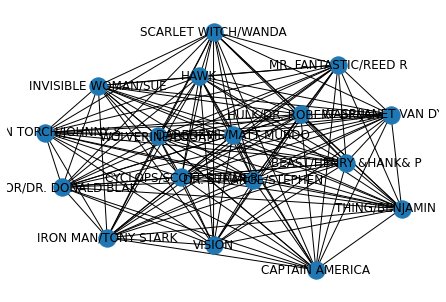

In [48]:
plt.clf()
nx.draw(subsetA, with_labels=True)
plt.show()

In [49]:
nx.info(subsetB)

'Graph with 3 nodes and 3 edges'

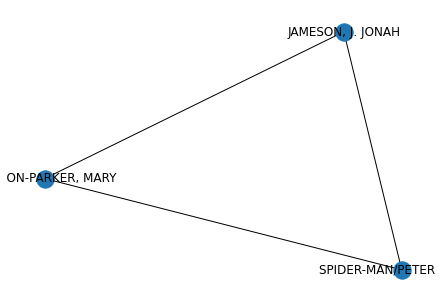

In [50]:
plt.clf()
nx.draw(subsetB, with_labels=True)
plt.show()

### Functionality 5 - Extracting Communities

In [10]:
# remove the node with highest EBC score from the graph
def removeEdge(graph):
	# We use capacity attribute of edges here as weight because we want heroes that are mostly together in comics to be in the same community
	G_dict = nx.edge_betweenness_centrality(graph, weight='capacity')

	edge = sorted(G_dict.items(), key=lambda item: item[1], reverse = True)[0][0]
	graph.remove_edge(edge[0], edge[1])

	return graph

# we remove nodes with highest EBC score until we have only one connected component
def girvanNewman(graph):
	nConnectedComponents = nx.number_connected_components(graph)
	min_edges = 0

	while(nConnectedComponents == 1):
		graph = removeEdge(graph.copy())
		nConnectedComponents = nx.number_connected_components(graph)
		min_edges += 1

	return graph, min_edges

# function_5 takes in input some variable arguments in kwargs that must contain Hero_1 and Hero2 values
def function_5(G, N=0, **kwargs) :

	# we use divise method with Girvan Newman algorithm to extract communities from the graph
	G, min_edges = girvanNewman(G)

	# we extract the communities of the new graph
	communities = []
	connectedComponents = nx.connected_components(G)
	for community in connectedComponents :
		communities.append(community)

	# we check if hero1 and hero2 are in a same community
	same_community = False
	for community in communities :
		if kwargs['Hero_1'] in community and kwargs['Hero_2'] in community :
			same_community = True

	return min_edges, communities, same_community


In [39]:
min_edges, communities, same_community = ControllerSystem(5, G_heroes, 50, Hero_1='PUNISHER II/FRANK CA', Hero_2='HULK/DR. ROBERT BRUC')

In [40]:
same_community

False

In [41]:
min_edges

327

In [42]:
len(communities)

2

In [43]:
communities

[{'ANGEL/WARREN KENNETH',
  'ANT-MAN/DR. HENRY J.',
  'BEAST/HENRY &HANK& P',
  "BLACK PANTHER/T'CHAL",
  'BLACK WIDOW/NATASHA',
  'CANNONBALL II/SAM GU',
  'CAPTAIN AMERICA',
  'CAPTAIN BRITAIN/BRIA',
  'COLOSSUS II/PETER RA',
  'CYCLOPS/SCOTT SUMMER',
  'DAREDEVIL/MATT MURDO',
  'DR. DOOM/VICTOR VON',
  'DR. STRANGE/STEPHEN',
  'FURY, COL. NICHOLAS',
  'HAWK',
  'HERCULES [GREEK GOD]',
  'HULK/DR. ROBERT BRUC',
  'HUMAN TORCH/JOHNNY S',
  'ICEMAN/ROBERT BOBBY',
  'INVISIBLE WOMAN/SUE',
  'IRON MAN/TONY STARK',
  'JAMESON, J. JONAH',
  'JARVIS, EDWIN',
  'JONES, RICHARD MILHO',
  'MARVEL GIRL/JEAN GRE',
  'MR. FANTASTIC/REED R',
  'NELSON, FRANKLIN FOG',
  'NIGHTCRAWLER/KURT WA',
  'ODIN [ASGARDIAN]',
  'PARKER, MAY',
  'PROFESSOR X/CHARLES',
  'QUICKSILVER/PIETRO M',
  'RICHARDS, FRANKLIN B',
  'ROBERTSON, JOE',
  'ROGUE /',
  'SCARLET WITCH/WANDA',
  'SHADOWCAT/KATHERINE',
  'SHE-HULK/JENNIFER WA',
  'SILVER SURFER/NORRIN',
  'SPIDER-MAN/PETER PARKER',
  'STORM/ORORO MUNROE S',
  'S

## 3. Frontend Implementation

### Visualization 1 - Visualize some features of the network

### Visualization 2 - Visualize centrality measure

### Visualization 3 - Visualize the shortest-ordered route

### Visualization 4 - Visualize the disconnected graph

### Visualization 5 - Visualize the communities